In [16]:
%pylab inline
import numpy as np
import torch
import os
import pandas as pd

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch import autograd
from torch.autograd import Variable
import nibabel as nib
from torch.utils.data.dataset import Dataset
from torch.utils.data import dataloader

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from nilearn import plotting
from ADNI_dataset import *
from BRATS_dataset import *
from ATLAS_dataset import *
from utils import *

import pytorch_ssim
from ipdb import set_trace

Populating the interactive namespace from numpy and matplotlib


/usr/local/miniconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['Generator', 'plotting', 'resize', 'disp']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Configuration

In [21]:
# used to store the MMD ans MS-SSIM
try:
    os.mkdir('./test_data')
except FileExistsError:
    pass
gpu = True
workers = 4
BATCH_SIZE = 8
latent_dim = 1000

Use_BRATS = False
Use_ATLAS = False

In [22]:
trainset = ADNIdataset(augmentation=True)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)
#'flair' or 't2' or 't1ce'
# trainset = BRATSdataset(imgtype='flair')
# train_loader = torch.utils.data.DataLoader(trainset,batch_size = BATCH_SIZE, shuffle=True,
#                                                num_workers=workers)

# trainset = ATLASdataset(augmentation=True)
# train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
#                                           shuffle=True,num_workers=workers)

gen_load = inf_train_gen(train_loader)

## Pre-trained Generator Load

In [29]:
#-------------------------------------------
#Choose the Model you want!
from Model_alphaWGAN import Generator
from Model_alphaWGAN import Discriminator
# from Model_alphaGAN import Generator
# from Model_VAEGAN import Generator
# from Model_WGAN import Generator
#-------------------------------------------

G = Generator(noise=latent_dim).cuda()
E = Discriminator(out_class = latent_dim, is_dis=False).cuda()
#-----------------------
#Load Pre-trained model
#-----------------------

#------------Trained Model of ADNI dataset---------------------
G.load_state_dict(torch.load('./checkpoint/G_iter12000.pth')) # Alpha-WGAN-GP
# E.load_state_dict(torch.load('./trained/E_iter12500.pth')) # Alpha-WGAN-GP Encoder
# G.load_state_dict(torch.load('./trained/G_VG_iter24552.pth')) #VAE-GAN
# G.load_state_dict(torch.load('./checkpoint/Alpha_G.pth')) #Alpha-GAN
# G.load_state_dict(torch.load('./checkpoint/G_W_iter3000.pth')) #WGAN-GP

#------------Trained Model of ATLAS dataset---------------------
# G.load_state_dict(torch.load('./checkpoint/Ours_at_G.pth'))

#------------Trained Models of BRATS dataset---------------------
# G.load_state_dict(torch.load('./checkpoint/Ours_fl_G.pth'))
# G.load_state_dict(torch.load('./checkpoint/Ours_t2_G.pth'))

Fake Image - slice series visualization

You can change the axis (x , y , z ) by changing  display_mode = 'x' / 'y' / 'z'

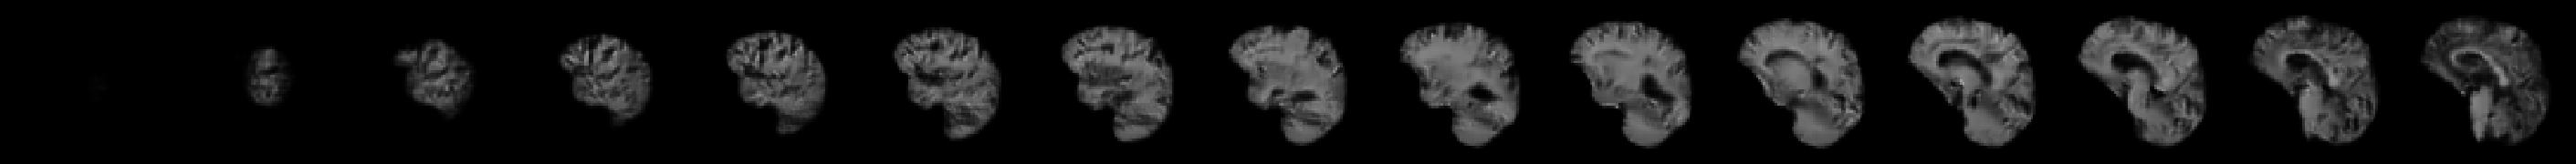

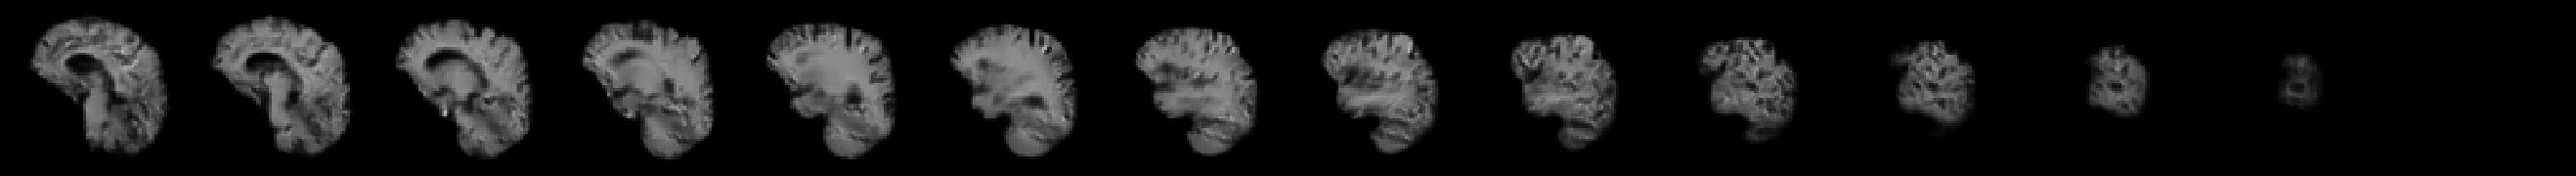

In [24]:
Show_color = False

noise = torch.randn(1, latent_dim).cuda()
fake_image = G(noise)
featmask = np.squeeze(fake_image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))

arr1 = [4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
arr2 = [34,36,38,40,42,44,46,48,50,52,54,56,58,60]
if Show_color:
    disp = plotting.plot_img(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False,positions=True)
    plotting.show()
    disp=plotting.plot_img(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()
else:
    disp = plotting.plot_anat(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    plotting.show()
    # disp.annotate(size=25,left_right=False)
    disp=plotting.plot_anat(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()

Fake Image - Center cut slices Visualization

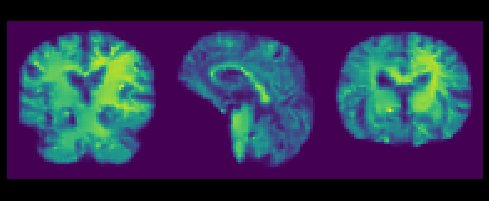

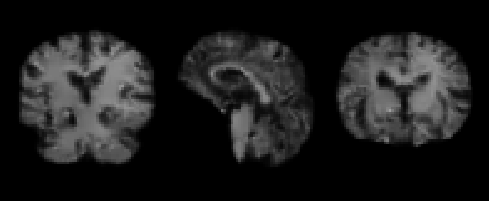

In [25]:
noise = Variable(torch.randn((1, 1000)).cuda())
# fake_image = G(noise)
featmask = np.squeeze(fake_image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
plotting.plot_img(featmask,cut_coords=(32,32,32),draw_cross=False,annotate=False,black_bg=True)
plotting.plot_anat(featmask,cut_coords=(32,32,32),draw_cross=False,annotate=False,black_bg=True)
plotting.show()

Real Image - Slice series visualization

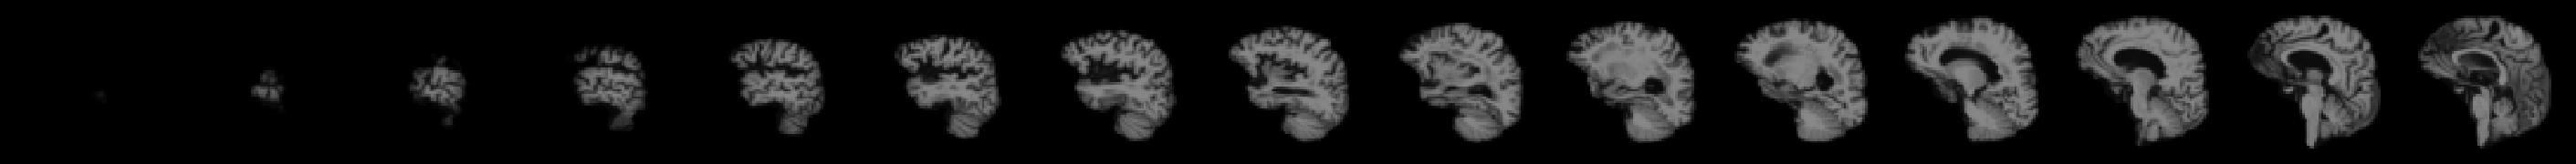

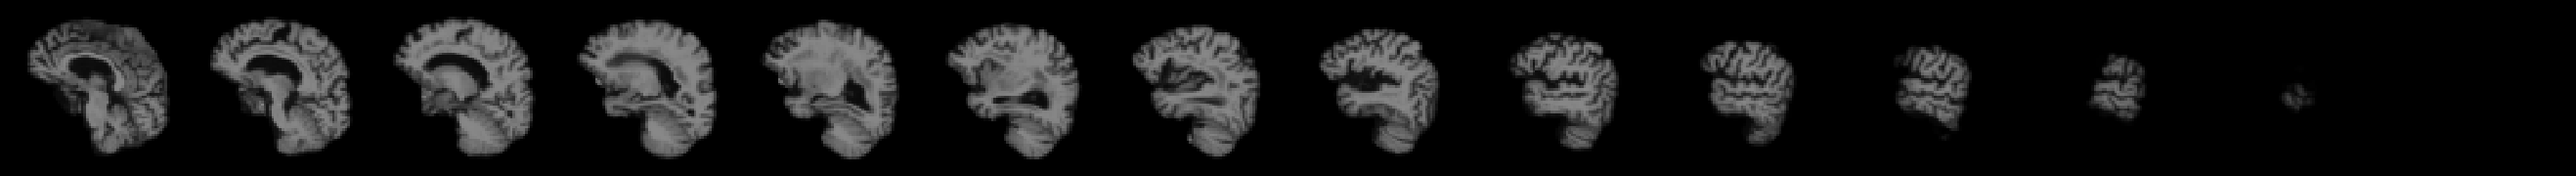

In [26]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)
gen_load = inf_train_gen(train_loader)

Show_color = False

image = gen_load.__next__()
featmask = np.squeeze(image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
arr1 = [4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
arr2 = [34,36,38,40,42,44,46,48,50,52,54,56,58,60]

if Show_color:
    disp = plotting.plot_img(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False,positions=True)
    plotting.show()
    disp=plotting.plot_img(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()
else:
    disp = plotting.plot_anat(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    plotting.show()
    # disp.annotate(size=25,left_right=False)
    disp=plotting.plot_anat(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()

# MS-SSIM Calculation

In [13]:
# sum_ssim = 0
# for k in range(20):
#     for i,dat in enumerate(train_loader):
#         if len(dat)!=2:
#             break
#         img1 = dat[0]
#         img2 = dat[1]

#         msssim = pytorch_ssim.msssim_3d(img1,img2)
#         sum_ssim = sum_ssim+msssim
#     print(sum_ssim/((k+1)*(i+1)))

In [ ]:
sum_ssim = 0
for i in range(1000):
    noise = Variable(torch.randn((2, 1000)).cuda())
    fake_image = G(noise)

    img1 = fake_image[0]
    img2 = fake_image[1]

    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    if i % 100 == 0:
        print(sum_ssim/1000)
print(sum_ssim/1000)

# MS-SSIM for real images

In [ ]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)
test_loader = inf_train_gen(train_loader)
i = 0
sum_ssim = 0
while i < 494:
    img1, img2 = test_loader.__next__()
    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    i += 1
    if i % 100 == 0:
        print(i, sum_ssim/ (494 * 2))
        
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)
test_loader = inf_train_gen(train_loader)
while i < 494 * 2:
    img1, img2 = test_loader.__next__()
    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    i += 1
    if i % 100 == 0:
        print(i, sum_ssim/ (494 * 2))
print(sum_ssim/(494 * 2))

# Maximum-Mean Discrepancy Score

In [ ]:
# read csv if exists
if os.path.exists('./test_data/mmd.csv'):
    # get the latest index
    df = pd.read_csv('./test_data/mmd.csv')
    start = int(df.iloc[-1]['index'])
else:
    df = pd.DataFrame({'index': [], 'mmd_score': []})
    start = 0 

for p in G.parameters():
    p.requires_grad = False
for s in range(start, 100):
    distmean = 0.0
    for i,(y) in enumerate(train_loader):
        y = Variable(y).cuda()
        noise = Variable(torch.randn((y.size(0), 1000)).cuda())
        x = G(noise)
        B = y.size(0)
        x = x.view(x.size(0), x.size(2) * x.size(3)*x.size(4))
        y = y.view(y.size(0), y.size(2) * y.size(3)*y.size(4))

        xx, yy, zz = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

        beta = (1./(B*B))
        gamma = (2./(B*B)) 

        Dist = beta * (torch.sum(xx)+torch.sum(yy)) - gamma * torch.sum(zz)
        distmean += Dist

    mean = (distmean/(i+1)).item()
    print(f'\nCount: {s} Mean: {mean}')
    # write scores to csv
    df = df.append(pd.DataFrame({
        'index': [s],
        'mmd_score': [mean]
    }))
    df.to_csv('./test_data/mmd.csv', index=False)

meanarr = numpy.array(df.iloc[:]['mmd_score'].tolist())
print('Total_mean:'+str(np.mean(meanarr))+' STD:'+str(np.std(meanarr)))

### calculate mmd

In [ ]:
df = pd.read_csv('./test_data/mmd.csv')
mmds = np.array(df.iloc[:]['mmd_score'].to_list())
mmds.mean()

### Images PCA Visualization

In [ ]:
sample_df = pd.DataFrame()
real_df = pd.DataFrame()
for i in range(0, 12001, 500):
    G.load_state_dict(torch.load(f'./checkpoint/G_iter{i}.pth'))
    viz_pca(G, trainset, latent_size=latent_dim, index=i)

In [ ]:
def show_pca_cluster(x, PC_list, interval=3):
    for i in range(x, x+interval):
        sample_ind = PC_list[i][2]
        feat = sample_df.iloc[int(sample_ind)].to_numpy().reshape((64, 64, 64))
        featmask = nib.Nifti1Image(feat,affine = np.eye(4))
        plotting.plot_img(featmask, title=f'x_val: {round(PC_list[i][0], 2)} y_val: {round(PC_list[i][1], 2)} sample_index: {int(sample_ind)}')
        plotting.show()

# concatenate the sample index 
PC_list = list(np.concatenate((PCs, np.array([i for i in range(512)]).reshape(512, 1)), 1))
# sort by x or y of PCAs
PC_list.sort(key=lambda x: x[1])

# for i in range(0, 512, 60):
#     show_pca_cluster(i, PC_list, 1)

show_pca_cluster(0, PC_list, 10)



### visualize all training images

In [14]:
viz_all_imgs('../../ADNI', [0])

FileNotFoundError: [Errno 2] No such file or directory: '../../ADNI'

### loss check

       index   l1_loss     d_recon     d_fake      d_real      d_loss  \
0          0  9.109800   -0.097666  -0.004112  -15.376379    0.101778   
1          1  8.027243   -5.291284  -0.099855  -22.755638    5.391138   
2          2  6.847758    2.364265   0.587298  -26.577526   -2.951563   
3          3  5.913009    4.026887  -1.406777  -31.672987   -2.620110   
4          4  5.121800    2.297638  -1.268362  -37.993416   -1.029277   
...      ...       ...         ...        ...         ...         ...   
29588  29588  0.765538 -102.470184 -87.714905  178.550980  190.185089   
29589  29589  0.788200 -103.048645 -87.501648  169.865265  190.550293   
29590  29590  0.713613 -103.200851 -89.595703  171.570892  192.796555   
29591  29591  0.726734 -103.544754 -90.691513  165.529236  194.236267   
29592  29592  0.730384 -103.513550 -91.649689  176.577026  195.163239   

            cd_loss  cd_zrand_loss      gp_r      gp_h       gp_cd  \
0         -0.059703      -0.117823  2.181973  0.87294

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

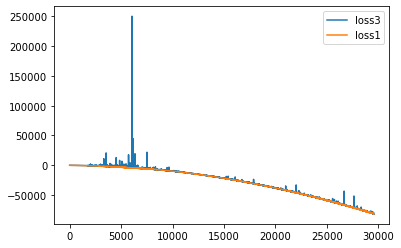

<Figure size 28800x28800 with 0 Axes>

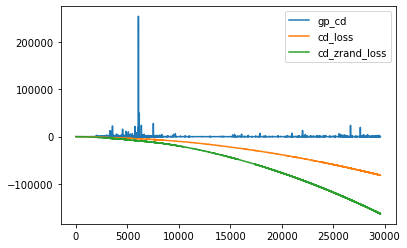

<Figure size 432x288 with 0 Axes>

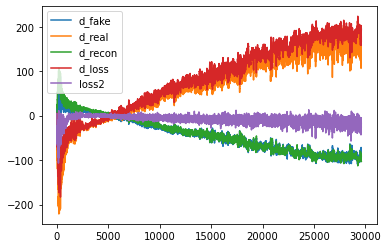

<Figure size 432x288 with 0 Axes>

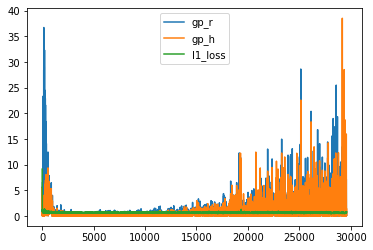

In [30]:
loss_df = load_loss(path='./checkpoint/loss.csv')
print(loss_df)
plt.figure()
loss_df[['loss3', 'loss1']].plot()
plt.figure(figsize=(400, 400))
loss_df[['gp_cd', 'cd_loss', 'cd_zrand_loss']].plot()
plt.figure()
loss_df[['d_fake', 'd_real', 'd_recon', 'd_loss', 'loss2']].plot()
plt.figure()
loss_df[['gp_r', 'gp_h', 'l1_loss']].plot()

### latent vector pca

index: 0, sample_mean: -0.05831123888492584, yellow_mean: 0.0011192515958100557


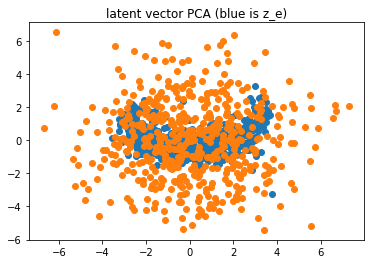

index: 0, sample_mean: -0.4705386161804199, yellow_mean: -0.00017694653070066124


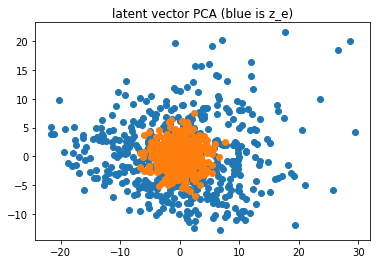

index: 0, sample_mean: 0.0005756927421316504, yellow_mean: 0.0019411236280575395


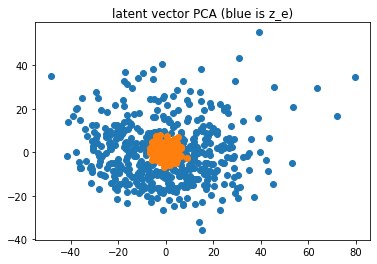

index: 0, sample_mean: -0.2259691059589386, yellow_mean: -0.0007769198273308575


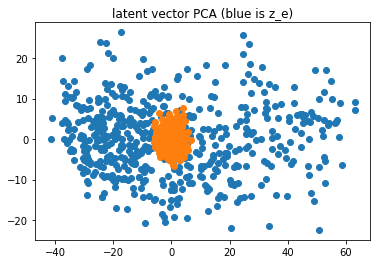

index: 0, sample_mean: -0.2917918562889099, yellow_mean: 1.6605481505393982e-05


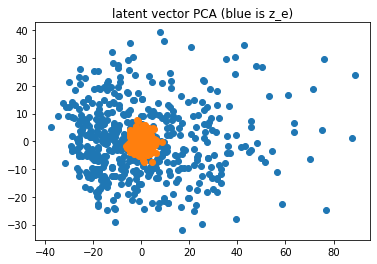

index: 0, sample_mean: 0.07091514766216278, yellow_mean: 2.2382941097021103e-05


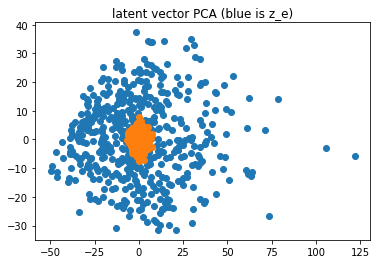

index: 0, sample_mean: 0.28061285614967346, yellow_mean: 0.0018739494262263179


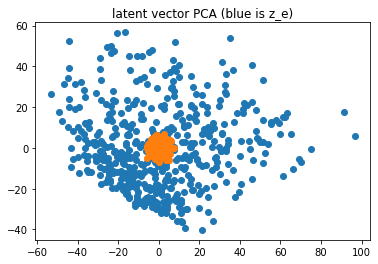

index: 0, sample_mean: 0.34344854950904846, yellow_mean: -0.0021804317366331816


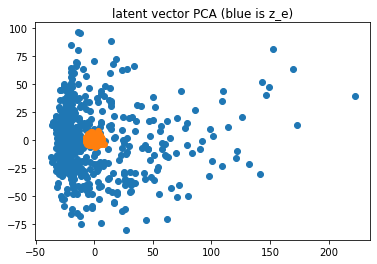

index: 0, sample_mean: 0.4820067584514618, yellow_mean: 0.0007081441581249237


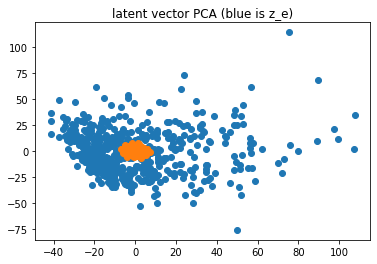

index: 0, sample_mean: 0.6696888208389282, yellow_mean: -0.0014605007600039244


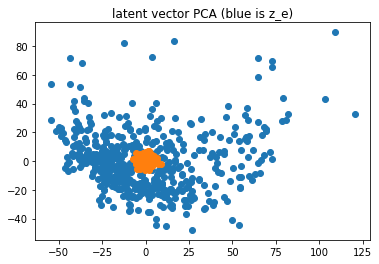

index: 0, sample_mean: 0.818001925945282, yellow_mean: -0.002101887483149767


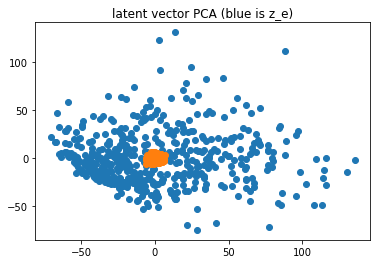

index: 0, sample_mean: 0.2433597445487976, yellow_mean: -0.0016589827137067914


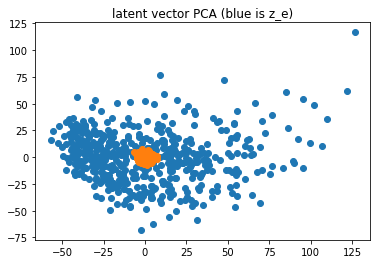

index: 0, sample_mean: 0.3451605439186096, yellow_mean: 0.002145727165043354


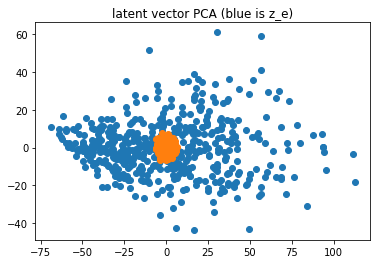

index: 0, sample_mean: 0.7809234261512756, yellow_mean: -0.0011704323114827275


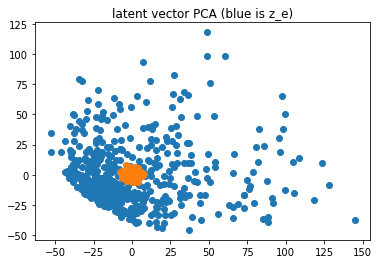

index: 0, sample_mean: 0.8001927733421326, yellow_mean: 0.002963559702038765


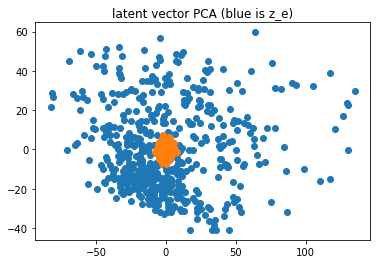

index: 0, sample_mean: 0.7552796602249146, yellow_mean: -0.0003488065558485687


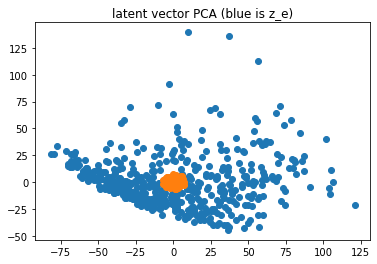

index: 0, sample_mean: 0.40115320682525635, yellow_mean: -0.0015621893107891083


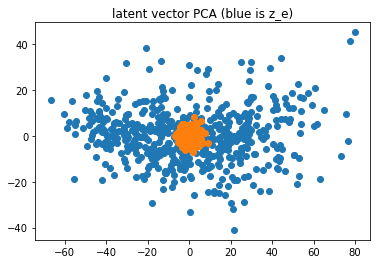

In [ ]:
for i in range(0, 200001, 500):
    E.load_state_dict(torch.load(f'./checkpoint/E_iter{i}.pth'))
    viz_pca(E, trainset, latent_size=latent_dim, index=i, is_cd=True)

### Calculate the paddings of fake images

In [ ]:
G = Generator(noise=1000).cuda()
G.load_state_dict(torch.load('./trained/G_iter12500.pth'))

def get_padding(feat, axis=0):
    feat = np.swapaxes(feat, 0, axis)
    output = [0, 0]
    for i in range(feat.shape[0]):
#         print(feat[i].sum())
        if feat[i].sum() > -4000:
            output[0] = i
            break
    for i in range(feat.shape[0] - 1, -1, -1):
        if feat[i].sum() > -4000:
            output[1] = feat.shape[0] - i - 1
            break
    return output
    
for i in range(512):
    noise = torch.rand((1, 1000)).cuda()
    img = G(noise)
    featmask = np.squeeze((0.5*img+0.5).detach().cpu().numpy())
    print(f'ind: {i} padding 0-axis: {get_padding(featmask, 0)}', end=' ')
    print(f'ind: {i} padding 1-axis: {get_padding(featmask, 1)}', end=' ')
    print(f'ind: {i} padding 2-axis: {get_padding(featmask, 2)}')
#     featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
#     plotting.plot_img(featmask, title=f'ind: {i}')
#     plotting.show()

### intensity range check

In [ ]:
trainset = ADNIdataset(augmentation=True, img_size=64, normalization=False)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)
for featmask in inf_train_gen(train_loader):
#     noise = torch.rand((1, 1000)).cuda()
#     featmask= G(noise)
#     featmask = np.squeeze((0.5*featmask+0.5).detach().cpu().numpy())
    lo, hi = featmask.min(), featmask.max()
    print(f'lo: {lo} hi: {hi}')
#     featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
#     plotting.plot_img(featmask, title=f'ind: {i}')
#     plotting.show()
    